In [17]:
import pandas as pd
from sqlalchemy import create_engine 
import pyodbc
import matplotlib.pyplot as plt

In [33]:
def conecto():
    server = '157.92.26.17,1443'
    database = 'AdventureWorks2019'
    username = 'Alumno'
    password = 'mrcd2025'
    
    # Agregar username y password a la cadena de conexión
    connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    
    engine = create_engine(connection_string)
    return engine

engine = conecto()


## Retencion de clientes

In [34]:
### Por ahi una forma mas corta de hacer este roll back estaria bien
with engine.connect() as connection:
    trans = connection.begin()
    try:
        # Aquí iría tu código que podría fallar
        pass
    except Exception as e:
        trans.rollback()
        print("Se hizo rollback por error:", e)
    else:
        trans.commit()

## Cuantos clientes hay en cada año?

C:\Users\Federico\AppData\Local\Temp\ipykernel_6888\3271575980.py:1: SAWarning: transaction already deassociated from connection
  trans.rollback()


,año,cantidad_clientes
0,2011,1406
1,2012,3162
2,2013,11095
3,2014,10354


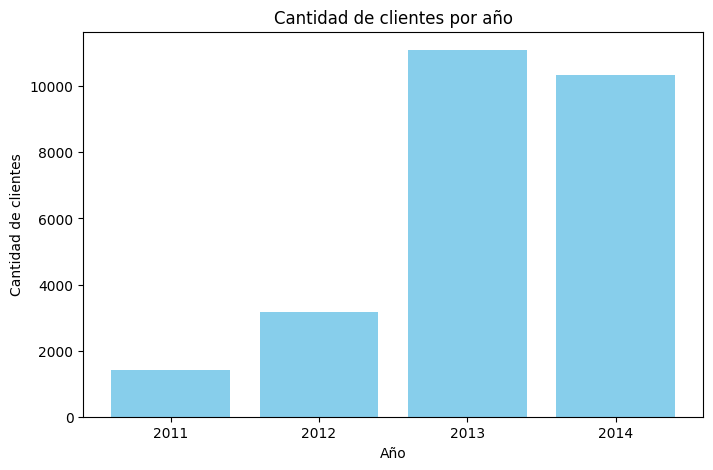

In [35]:
trans.rollback()
query = """
SELECT 
    YEAR(OrderDate) AS año,
    COUNT(DISTINCT CustomerID) AS cantidad_clientes
FROM Sales.SalesOrderHeader
WHERE YEAR(OrderDate) BETWEEN 2011 AND 2014
GROUP BY YEAR(OrderDate)
ORDER BY año
"""
clientes_por_año = pd.read_sql(query, engine)
display(clientes_por_año)

# Agregar gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(clientes_por_año['año'], clientes_por_año['cantidad_clientes'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Cantidad de clientes')
plt.title('Cantidad de clientes por año')
plt.xticks(clientes_por_año['año'])
plt.show()

## Retencion de clientes

Los clientes que compraron en 2011 se van o se quedan ? 

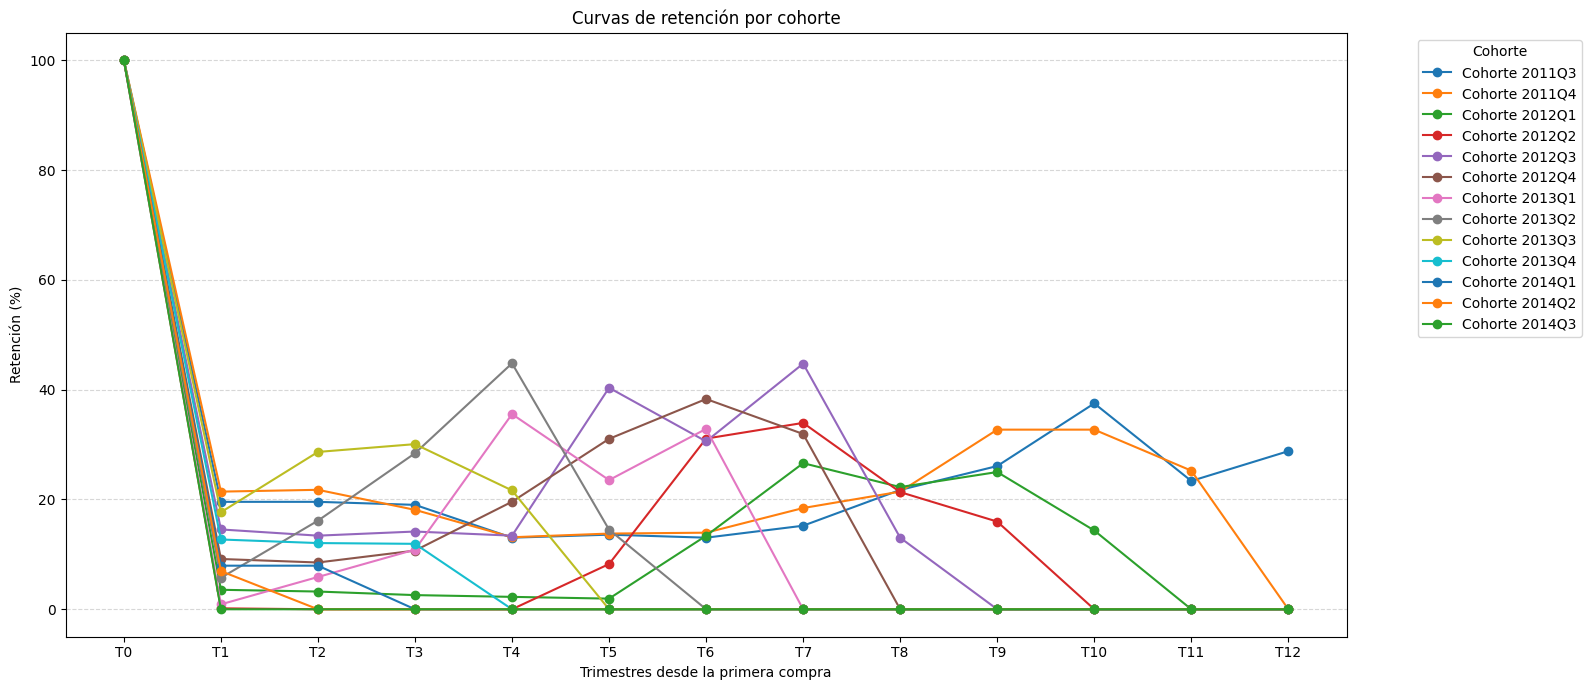

In [36]:
query = (""" 
WITH primera_compra AS (
    SELECT 
        CustomerID,
        MIN(DATEPART(YEAR, OrderDate) * 4 + DATEPART(QUARTER, OrderDate) - 1) AS trimestre_primera_compra,
        MIN(OrderDate) AS fecha_primera_compra
    FROM Sales.SalesOrderHeader
    WHERE OrderDate >= '2011-05-31' AND OrderDate < '2014-06-30'  -- Agregar filtro aquí también
    GROUP BY CustomerID
),
compras_por_cliente AS (
    SELECT 
        soh.CustomerID,
        pc.trimestre_primera_compra AS cohorte,
        DATEPART(YEAR, soh.OrderDate) * 4 + DATEPART(QUARTER, soh.OrderDate) - 1 AS trimestre_observado,
        pc.fecha_primera_compra
    FROM Sales.SalesOrderHeader soh
    JOIN primera_compra pc ON soh.CustomerID = pc.CustomerID
    WHERE soh.OrderDate >= '2011-05-31' AND soh.OrderDate < '2014-06-30'  -- Filtro también aquí
),
clientes_cohorte_retencion AS (
    SELECT 
        cohorte,
        trimestre_observado - cohorte AS trimestres_desde_cohorte,
        COUNT(DISTINCT CustomerID) AS clientes_retenidos
    FROM compras_por_cliente
    GROUP BY cohorte, trimestre_observado - cohorte
),
tabla_pivot AS (
    SELECT 
        cohorte,
        ISNULL([0], 0) AS trimestre0,
        ISNULL([1], 0) AS trimestre1,
        ISNULL([2], 0) AS trimestre2,
        ISNULL([3], 0) AS trimestre3,
        ISNULL([4], 0) AS trimestre4,
        ISNULL([5], 0) AS trimestre5,
        ISNULL([6], 0) AS trimestre6,
        ISNULL([7], 0) AS trimestre7,
        ISNULL([8], 0) AS trimestre8,
        ISNULL([9], 0) AS trimestre9,
        ISNULL([10], 0) AS trimestre10,
        ISNULL([11], 0) AS trimestre11,
        ISNULL([12], 0) AS trimestre12
    FROM clientes_cohorte_retencion
    PIVOT (
        SUM(clientes_retenidos)
        FOR trimestres_desde_cohorte IN (
            [0], [1], [2], [3], [4], [5], [6], [7],
            [8], [9], [10], [11], [12]
        )
    ) AS pvt
)
SELECT 
    cohorte,
    -- CORRECCIÓN: Convertir de vuelta usando la lógica inversa correcta
    CAST(((cohorte + 1) / 4) AS VARCHAR) + 'Q' + CAST(((cohorte + 1) % 4) + 1 AS VARCHAR) AS periodo_cohorte_corregido,
    
    trimestre0,
    trimestre1,
    trimestre2,
    trimestre3,
    trimestre4,
    trimestre5,
    trimestre6,
    trimestre7,
    trimestre8,
    trimestre9,
    trimestre10,
    trimestre11,
    trimestre12,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre0 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t0_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre1 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t1_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre2 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t2_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre3 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t3_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre4 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t4_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre5 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t5_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre6 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t6_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre7 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t7_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre8 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t8_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre9 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t9_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre10 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t10_pct,
    CASE WHEN trimestre0 > 0 THEN ROUND((trimestre11 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t11_pct,
	CASE WHEN trimestre0 > 0 THEN ROUND((trimestre12 * 100.0 / trimestre0), 2) ELSE 0 END AS ret_t12_pct
FROM tabla_pivot
ORDER BY cohorte;
""")
retencion_clientes = pd.read_sql(query, engine)

# Graficar curvas de retención para cada cohorte utilizando las columnas ret_t0_pct, ret_t1_pct, ..., ret_t12_pct

import matplotlib.pyplot as plt

# Seleccionamos las columnas de porcentaje de retención
trimestres_pct = [f'ret_t{i}_pct' for i in range(13)]
labels_trimestres = [f'T{i}' for i in range(13)]

plt.figure(figsize=(16, 7))

# Usar la columna 'periodo_cohorte_corregido' como etiqueta de cohorte si existe, si no, usar 'cohorte'
if 'periodo_cohorte_corregido' in retencion_clientes.columns:
    cohortes = retencion_clientes['periodo_cohorte_corregido']
else:
    cohortes = retencion_clientes['cohorte'].astype(str)

for idx, cohorte in enumerate(cohortes):
    retencion = retencion_clientes.loc[idx, trimestres_pct].values
    plt.plot(labels_trimestres, retencion, marker='o', label=f'Cohorte {cohorte}')

plt.title('Curvas de retención por cohorte')
plt.xlabel('Trimestres desde la primera compra')
plt.ylabel('Retención (%)')
plt.legend(title='Cohorte', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

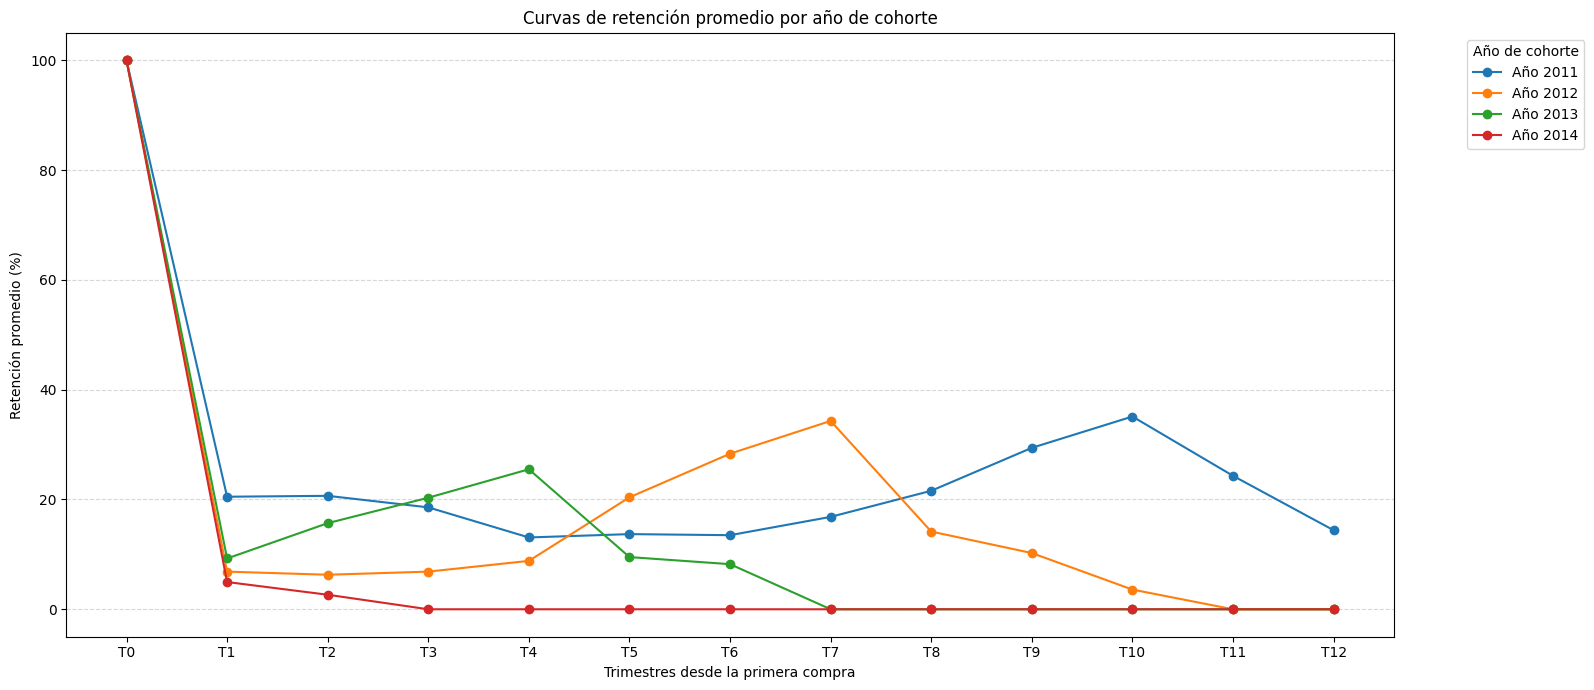

In [37]:
# Graficar curvas de retención usando los porcentajes ya calculados en SQL
# Ahora, un solo gráfico, pero con una curva para cada cohorte de un año específico

# Seleccionamos todas las columnas de porcentaje de retención calculadas por SQL (t0 a t12)
trimestres_pct = [f'ret_t{i}_pct' for i in range(13)]
labels_trimestres = [f'T{i}' for i in range(13)]

# Extraer el año de la cohorte (asumiendo formato '2011Q1', '2012Q2', etc.)
if 'periodo_cohorte_corregido' in retencion_clientes.columns:
    retencion_clientes['año_cohorte'] = retencion_clientes['periodo_cohorte_corregido'].str[:4]
    cohortes = retencion_clientes['periodo_cohorte_corregido']
else:
    # Si solo hay número de cohorte, usarlo como año
    retencion_clientes['año_cohorte'] = retencion_clientes['cohorte'].astype(str)
    cohortes = retencion_clientes['cohorte']

# Obtener los años únicos de las cohortes
anios = sorted(retencion_clientes['año_cohorte'].unique())

plt.figure(figsize=(16, 7))

for anio in anios:
    # Filtrar cohortes de ese año
    df_anio = retencion_clientes[retencion_clientes['año_cohorte'] == anio]
    # Promediar la retención de todas las cohortes de ese año (por trimestre)
    if not df_anio.empty:
        retencion_media = df_anio[trimestres_pct].mean(axis=0)
        plt.plot(labels_trimestres, retencion_media.values, marker='o', label=f'Año {anio}')

plt.title('Curvas de retención promedio por año de cohorte')
plt.xlabel('Trimestres desde la primera compra')
plt.ylabel('Retención promedio (%)')
plt.legend(title='Año de cohorte', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()